# Hodgkin-Huxley IK Model

This example shows how the Hodgkin-Huxley potassium current (IK) toy model can be used.

This model recreates an experiment where a sequence of voltages is applied to a [giant axon from a squid](https://en.wikipedia.org/wiki/Squid_giant_axon), and the resulting potassium current is measured. For information on the science behind it, see the [original 1952 paper](https://doi.org/10.1113/jphysiol.1952.sp004764).


In [1]:
import pints
import pints.toy
import matplotlib.pyplot as plt
import numpy as np

model = pints.toy.HodgkinHuxleyIKModel()

We can get an example set of parameters using the `suggested_parameters()` method:

In [2]:
x0 = model.suggested_parameters()

The voltage protocol used in the model has a fixed duration, which we can see using `suggested_duration()`:

In [3]:
model.suggested_duration()

1200

And it can also provide a suggested sequence of sampling times:

In [4]:
times = model.suggested_times()

Using the suggested parameters and times, we can run a simulation:

In [5]:
values = model.simulate(x0, times)

This gives us all we need to create a plot of current versus time:

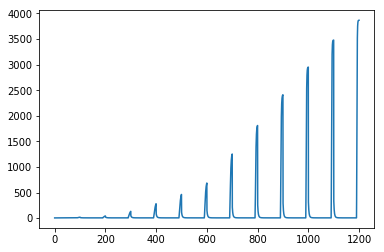

In [6]:
plt.figure()
plt.plot(times, values)
plt.show()

The voltage protocol used to generate this data consists of 12 segments, of 100ms each.
Each segment starts with 90ms at the _holding potential_, followed by a 10ms step to an increasing _step potential_.
During this step, a current is elicited, while the signal at the holding potential is almost zero.

A common way to represent this data is to show only the data during the step, and to _fold_ the steps over each other. This can be done using the `fold()` method:

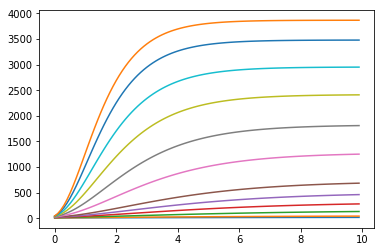

In [7]:
plt.figure()
for t, v in model.fold(times, values):
    plt.plot(t, v)
plt.show()

This recreates Figure 3 in the original paper. 

Now we will add some noise to generate some fake "experimental" data and try to recover the original parameters.

In [11]:
# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries one order of magnitude above and below the suggested values
lower = [x / 10.0 for x in x0]
upper = [x * 10.0 for x in x0]
boundaries = pints.Boundaries(lower, upper)

# Perform an optimization with boundaries and hints
middle = [0.5 * (u + l) for l, u in zip(lower, upper)]
sigma = [u - l for l, u in zip(lower, upper)]
optimiser = pints.Optimisation(score, middle, sigma, boundaries, method=pints.CMAES)
optimiser.set_log_to_screen(False)
found_parameters, found_score = optimiser.run()

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(x0[k]))

Found solution:          True parameters:
 1.00006893718352294e-02     1.00000000000000002e-02
 1.00955930488876007e+01     1.00000000000000000e+01
 9.93130067325077626e+00     1.00000000000000000e+01
 1.23241402504909225e-01     1.25000000000000000e-01
 8.10251116039019479e+01     8.00000000000000000e+01


We can then compare the true and fitted model output

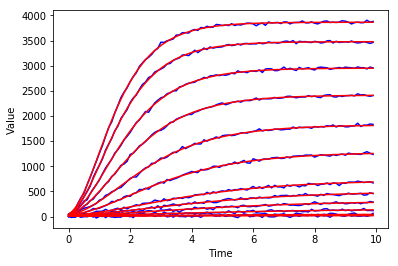

In [12]:
# Evaluate model at found parameters
found_values = problem.evaluate(found_parameters)

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
for t, v in model.fold(times, values):
    plt.plot(t, v, c='b', label='Noisy data')
for t, v in model.fold(times, found_values):
    plt.plot(t, v, c='r', label='Fit')
plt.show()